In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
# export
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# export
import sys
sys.path.insert(0,"/content/drive/My Drive/Colab Notebooks/exp")
from nb_04 import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Initial Setup



In [0]:
# Downloading data
x_train, y_train, x_valid, y_valid = get_data()

# Creating dataset
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

nh, bs = 50, 512

c = y_train.max().item() + 1
loss_func = F.cross_entropy

In [0]:
data = Databunch(*get_dls(train_ds, valid_ds, bs), c)

In [0]:
# export
def create_learner(model_func, loss_func, data):
  return Learner(*model_func(data), loss_func, data)

In [7]:
learn = create_learner(get_model, loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.65737140625, tensor(0.8074)]
valid: [0.3372231201171875, tensor(0.8980)]
train: [0.2957126171875, tensor(0.9144)]
valid: [0.23824892578125, tensor(0.9306)]
train: [0.2374569921875, tensor(0.9315)]
valid: [0.20041988525390625, tensor(0.9440)]


In [8]:
learn = create_learner(partial(get_model, lr=0.3), loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.76593484375, tensor(0.8013)]
valid: [0.35941875, tensor(0.8989)]
train: [0.3461725, tensor(0.9012)]
valid: [0.28937421875, tensor(0.9168)]
train: [0.29751837890625, tensor(0.9153)]
valid: [0.273209765625, tensor(0.9212)]


In [0]:
# export
def get_model_func(lr =0.5):
  return partial(get_model, lr=lr)

## Annealing

We define two new callbacks: the Recorder to save track of the loss and our scheduled learning rate, and a ParamScheduler that can schedule any hyperparameter as long as it's registered in the state_dict of the optimizer.

In [0]:
# export
class Recorder(Callback):
  def begin_fit(self):
    self.lrs, self.losses = [],[]

  def after_batch(self):
    if not self.in_train: return
    self.lrs.append(self.opt.param_groups[-1]['lr'])
    self.losses.append(self.loss.detach().cpu())

  def plot_lr(self): plt.plot(self.lrs)
  def plot_loss(self): plt.plot(self.losses)

class ParamScheduler(Callback):
  _order = 1
  def __init__(self, pname, sched_func):
    self.pname, self.sched_func = pname, sched_func

  def set_param(self):
    for pg in self.opt.param_groups:
      pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)

  def begin_batch(self):
    if self.in_train:
      self.set_param()


Let's start with a simple linear schedule going from start to end. It returns a function that takes a `pos` argument (going from 0 to 1) such that this function goes from `start` (at `pos=0`) to `end` (at `pos=1`) in a linear fashion.

In [0]:
def sched_lin(start, end):
  def _inner(start, end, pos):
    return start + pos * (end - start)
  return partial(_inner, start, end)

We can refactor this with a decorator.

In [0]:
# export
def annealer(f):
  def _inner(start, end):
    return partial(f, start, end)
  return _inner

@annealer
def sched_lin(start, end, pos):
  return start + pos * (end - start)

In [14]:
f = sched_lin(1,2)
f(0.3)

1.3

And here are other scheduler functions:

In [0]:
# export
@annealer
def sched_cos(start, end, pos): return start + (1+math.cos(math.pi*(1-pos))) * (end-start)/2

@annealer
def sched_no(start, end, pos): return start

@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

# This monkey-patch is there to be able to plot tensorss
torch.Tensor.ndim = property(lambda x: len(x.shape))

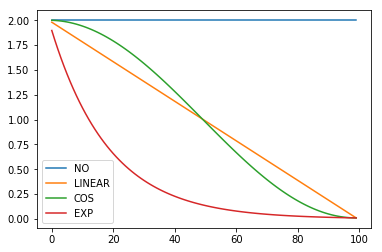

In [39]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01, 1, 100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
  f = fn(2, 1e-2)
  plt.plot(a, [f(o) for o in p], label=t)
plt.legend()

In practice, we'll often want to combine different schedulers, the following function does that: it uses `scheds[i]` for `pcts[i]` of the training.

In [0]:
# export
def combine_scheds(pcts, scheds):
  assert sum(pcts) == 1.
  pcts = tensor([0] + listify(pcts))
  assert torch.all(pcts >= 0)
  pcts = torch.cumsum(pcts, 0)
  def _inner(pos):
    idx = (pos >= pcts).nonzero().max()
    actual_pos = (pos-pcts[idx])/(pcts[idx+1]-pcts[idx])
    return scheds[idx](actual_pos)
  return _inner

Here is an example: use 30% of the budget to go from 0.3 to 0.6 following a cosine, then the last 70% of the budget to go from 0.6 to 0.2, still following a cosine.

In [0]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6),sched_cos(0.6, 0.2)])

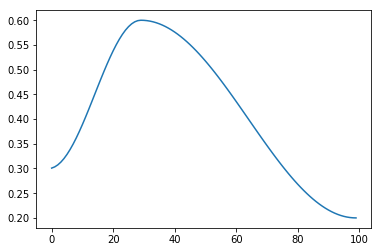

In [42]:
plt.plot(a, [sched(o) for o in p])

We can use it for training quite easily...


In [0]:
cbfs = [Recorder, 
        partial(AvgStatsCallback, accuracy), 
        partial(ParamScheduler,'lr', sched)]

In [0]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)

In [46]:
run.fit(5, learn)

train: [0.1923510546875, tensor(0.9452)]
valid: [0.18881964111328126, tensor(0.9454)]
train: [0.17562900390625, tensor(0.9490)]
valid: [0.15568135986328124, tensor(0.9575)]
train: [0.14970248046875, tensor(0.9575)]
valid: [0.13757437744140624, tensor(0.9622)]
train: [0.133344169921875, tensor(0.9620)]
valid: [0.12990335693359376, tensor(0.9639)]
train: [0.123899072265625, tensor(0.9647)]
valid: [0.124832177734375, tensor(0.9653)]


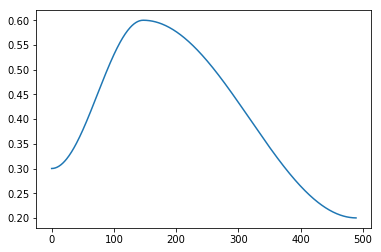

In [47]:
run.recorder.plot_lr()

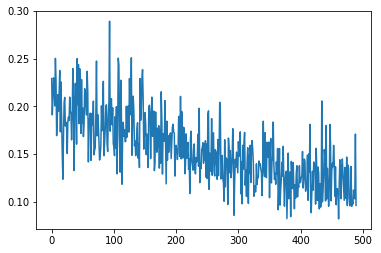

In [48]:
run.recorder.plot_loss()

##  Export

In [49]:
!pip install fire

     |████████████████████████████████| 81kB 3.8MB/s 
  Created wheel for fire: filename=fire-0.2.1-py2.py3-none-any.whl size=103527 sha256=668fb971e9fe71b847376a55caee9db2d7182e13bfbc2d37c03544256199c3a0
  Stored in directory: /root/.cache/pip/wheels/31/9c/c0/07b6dc7faf1844bb4688f46b569efe6cafaa2179c95db821da
Successfully built fire


In [50]:
!python "/content/drive/My Drive/Colab Notebooks/notebook2script.py" "/content/drive/My Drive/Colab Notebooks/05_anneal.ipynb"

Converted /content/drive/My Drive/Colab Notebooks/05_anneal.ipynb to /content/drive/My Drive/Colab Notebooks/exp/nb_05.py
